In [58]:
import glob
import pandas as pd
import numpy as np
from itertools import product
import networkx as nx
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'sklearn'

# 20210222

The goal of this notebook is to address the data normalization problem with files in [../data/all_stab_scores](../data/all_stab_scores). In short, I want to partition stability score CSV files such that each partition has its own Data Resource and schema. The columns in schema should be as "close" to the non-empty columns in the files of the partition as possible. At the same time, we want as few partitions as possible (otherwise, optimal solution would be a single Data Resource for each CSV file).

Continuation of [20210201](./20210201.ipynb) notebook. I'll probably use NetworkX instead of sknetwork this time.

### Links

* [Overview of graph clustering methods](https://www.csc2.ncsu.edu/faculty/nfsamato/practical-graph-mining-with-R/slides/pdf/Graph_Cluster_Analysis.pdf)

----

First step is to represent these files as a graph:

In [2]:
primary_keys = ['dataset', 'name']

In [3]:
all_fps = glob.glob("../data/all_stab_scores/og/*.csv")
all_fps

['../data/all_stab_scores/og/topology_mining_rd2.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/181114_IL_binders_FS.v2.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Inna.v7.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin_scrambled_controls_display_vector_2.rd4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin_display_vector_2.rd4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd1.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Eva1_scrambled_controls.v3.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Eva2.v7.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd3.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/100K_winter19.v3.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd4.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Longxing_scrambled_controls.v3

Get columns (excluding primary keys) in each CSV file, and assign an integer index for convenience:

In [4]:
def get_cols(fp, primary_keys: list = primary_keys) -> list:
    """Get columns in CSV file `fp`, and remove primary keys"""
    all_cols = pd.read_csv(fp).columns.tolist()
    return [c for c in all_cols if c not in primary_keys]
col_dict = {int_idx: get_cols(fp) for int_idx, fp in enumerate(all_fps)}

/Users/TASethanho/.pyenv/versions/3.8.3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3341: DtypeWarning: Columns (89) have mixed types.Specify dtype option on import or set low_memory=False.
  await eval(code_obj, self.user_global_ns, self.user_ns)


Set up a weighted adjacency matrix:

Iterate over every pair of files `(n1, n2)`:

In [5]:
def increment_weight(g, k, amt):
    current = g.nodes[k].get('weight', 0)
    g.nodes[k]['weight'] = amt + current
    return None

In [6]:
def get_graph_from_col_dict(g, col_dict, shared_thresh=30):
    for k1, k2 in product(*[list(col_dict.keys())] * 2):
        if k1 == k2:
            continue

        # determine which columns are shared
        cols1 = set(col_dict[k1])
        cols2 = set(col_dict[k2])
        shared = cols1.intersection(cols2)

        # add graph edge
        props = {
            'shared_cols': shared,
            'n_shared': len(shared)
        }
        if shared_thresh < props['n_shared']:
            g.add_edge(k1, k2, **props)
            increment_weight(g, k1, props['n_shared'])
    return None

In [18]:
g = nx.Graph()
get_graph_from_col_dict(g, col_dict, shared_thresh=0)

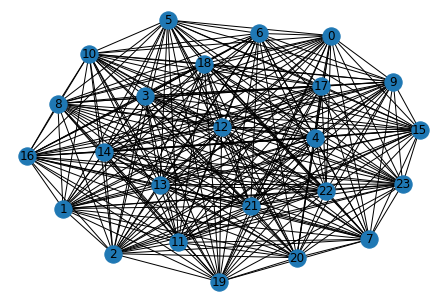

In [19]:
nx.draw(g, with_labels=True)

## Recursively Find Maximal Clique

The idea here is to find the maximal clique `c` in graph `G`, then recurse for the subgraph `G \ c` until termination (no cliques exist).

In [26]:
def scaling_max_clique(col_dict, max_thresh=86):
    cur_lmc, cur_mwt = float("inf"), float("inf")
    as_dict = list()
    for thresh in range(max_thresh + 1):
        g = nx.Graph()
        get_graph_from_col_dict(g, col_dict, thresh)
        mc, mwt = nx.max_weight_clique(g)

        if len(mc) <= 0:
            break

        as_dict.append({
            'thresh': thresh,
            'clique': mc,
            'weight_per_node': (mwt / len(mc)),
            'clique_occupancy': 100 * len(mc) / len(col_dict)
        })

        # logging
        if len(mc) < cur_lmc or mwt < cur_mwt:
            cur_lmc = len(mc)
            cur_mwt = mwt
            print(f"thresh: {thresh}, size: {len(mc)}, weight per node: {(mwt / len(mc)):.1f}, " +
                  f"clique_occupancy: {(100 * len(mc) / len(col_dict)):.2f}%")
    return as_dict

cliques_dict = scaling_max_clique(col_dict, max_thresh=130)

thresh: 0, size: 23, weight per node: 787.2, clique_occupancy: 95.83%
thresh: 1, size: 23, weight per node: 786.3, clique_occupancy: 95.83%
thresh: 6, size: 22, weight per node: 807.8, clique_occupancy: 91.67%
thresh: 7, size: 19, weight per node: 874.7, clique_occupancy: 79.17%
thresh: 12, size: 19, weight per node: 859.6, clique_occupancy: 79.17%
thresh: 14, size: 18, weight per node: 888.7, clique_occupancy: 75.00%
thresh: 15, size: 12, weight per node: 1110.3, clique_occupancy: 50.00%
thresh: 16, size: 12, weight per node: 1097.0, clique_occupancy: 50.00%
thresh: 20, size: 12, weight per node: 1095.3, clique_occupancy: 50.00%
thresh: 21, size: 12, weight per node: 1042.8, clique_occupancy: 50.00%
thresh: 22, size: 12, weight per node: 1006.2, clique_occupancy: 50.00%
thresh: 30, size: 12, weight per node: 993.7, clique_occupancy: 50.00%
thresh: 86, size: 11, weight per node: 966.1, clique_occupancy: 45.83%
thresh: 87, size: 7, weight per node: 610.3, clique_occupancy: 29.17%
thresh

Convert to DataFrame:

array([<AxesSubplot:xlabel='thresh'>, <AxesSubplot:xlabel='thresh'>],
      dtype=object)

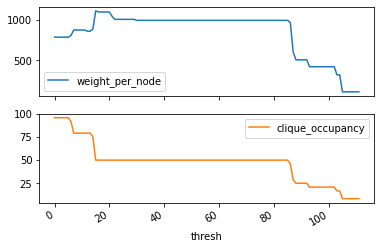

In [27]:
df = pd.DataFrame(cliques_dict)
df.set_index('thresh')
df.plot(x='thresh', subplots=True)

Visually, looks like there are two optimal `thresh` cutoffs at around 20 and 85. Each of these cliques contains about half of the nodes. Let's try using the `thresh = 86` clique for our grouping:

In [28]:
optimal = [c for c in cliques_dict if c['thresh'] == 86][0]
optimal

{'thresh': 86,
 'clique': [18, 4, 3, 0, 22, 17, 16, 14, 11, 9, 6],
 'weight_per_node': 966.0909090909091,
 'clique_occupancy': 45.833333333333336}

Let's see what happens if we partition into these two subgraphs:

In [42]:
def analyze_partitions(groups, col_dict):
    grp_lst = list()
    for group in groups:
        g = dict(shared_cols=set())
        for node in group:
            cols = col_dict[node]
            g['shared_cols'].update(cols)
                
        grp_lst.append(g)
    return grp_lst

in_clique = optimal['clique']
out_clique = [n for n in col_dict if n not in in_clique]
clique_result = analyze_partitions([in_clique, out_clique], col_dict)
clique_result

[{'shared_cols': {'base_sequence',
   'chip_name',
   'coding_dna_c',
   'coding_dna_t',
   'counts0_c',
   'counts0_t',
   'counts1_c',
   'counts1_t',
   'counts2_c',
   'counts2_t',
   'counts3_c',
   'counts3_t',
   'counts4_c',
   'counts4_t',
   'counts5_c',
   'counts5_t',
   'counts6_c',
   'counts6_t',
   'delta_llh1_c',
   'delta_llh1_t',
   'delta_llh2_c',
   'delta_llh2_t',
   'delta_llh3_c',
   'delta_llh3_t',
   'delta_llh4_c',
   'delta_llh4_t',
   'delta_llh5_c',
   'delta_llh5_t',
   'delta_llh6_c',
   'delta_llh6_t',
   'description',
   'downsamp_counts1_c',
   'downsamp_counts1_t',
   'downsamp_counts2_c',
   'downsamp_counts2_t',
   'downsamp_counts3_c',
   'downsamp_counts3_t',
   'downsamp_counts4_c',
   'downsamp_counts4_t',
   'downsamp_counts5_c',
   'downsamp_counts5_t',
   'downsamp_counts6_c',
   'downsamp_counts6_t',
   'ec50_95ci_c',
   'ec50_95ci_lbound_c',
   'ec50_95ci_lbound_t',
   'ec50_95ci_t',
   'ec50_95ci_ubound_c',
   'ec50_95ci_ubound_t',
   'e

# Rethinking

Okay, I think I've been phrasing this question wrong. What I actually want is not a partition of files, but rather a partition of columns. This means that columns should be nodes and edges should be files. Then, a minimum cut should tell us which groups of columns we should bin into each table.

----

We start by restructuring the dictionary of columns in each file to files that contain each column:

In [45]:
fdict = dict()
for file, cols in col_dict.items():
    for c in cols:
        if c in fdict:
            fdict[c].add(file)
        else:
            fdict[c] = set([file])
fdict

{'chip_name': {0, 17},
 'counts0_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'counts1_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'counts2_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'counts3_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'counts4_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'counts5_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'counts6_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'downsamp_counts1_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'downsamp_counts2_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'downsamp_counts3_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'downsamp_counts4_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'downsamp_counts5_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'downsamp_counts6_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'pred_counts1_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'pred_counts2_t': {0, 1, 3, 4, 6, 9, 11, 14, 16, 17, 18, 22},
 'pred_counts3_t': {0, 1, 3, 4, 6, 9, 11, 1

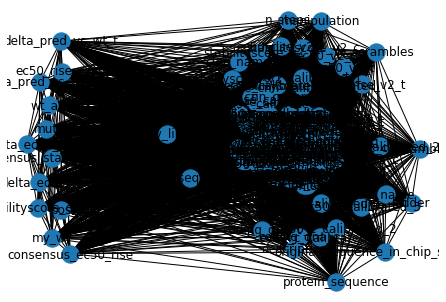

In [56]:
def get_graph_from_fdict(g, fdict, shared_thresh=0):
    for k1, k2 in product(*[list(fdict.keys())] * 2):
        if k1 == k2:
            continue

        # determine which files are shared
        f1 = set(fdict[k1])
        f2 = set(fdict[k2])
        shared = f1.intersection(f2)

        # add graph edge
        props = {
            'shared_files': shared,
            'weight': len(shared)
        }
        g.add_edge(k1, k2, **props)
    return None

g = nx.Graph()
get_graph_from_fdict(g, fdict)
nx.draw(g, with_labels=True)

In [55]:
mnc = nx.minimum_node_cut(g)
len(mnc), len(g)

(141, 142)